### importing all the libraries

In [201]:
import boto3
import os
from pathlib import Path
import glob
from os import listdir
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error
from math import sqrt


import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)


### Defining the Autoencoder Model Architerure.

The function takes no arguments and returns an autoencoder model.

It starts by defining an input layer input_img with a shape of (420, 540, 1) for grayscale images. The name of this layer is set to 'image_input'.

The code then defines the encoder part of the autoencoder:

It applies a 2D convolutional layer with 32 filters, a filter size of (3, 3), and ReLU activation. The padding is set to 'same', and the layer is named 'Conv1'.
It performs max pooling with a pool size of (2, 2) and padding set to 'same'. The layer is named 'pool1'.
Another 2D convolutional layer is applied with 64 filters, a filter size of (3, 3), and ReLU activation. The padding is set to 'same', and the layer is named 'Conv2'.
Another max pooling layer is applied with the same parameters as before, and the layer is named 'pool2'.
After the encoder part, the code defines the decoder part of the autoencoder:

A 2D convolutional layer with 64 filters, a filter size of (3, 3), and ReLU activation is applied. The padding is set to 'same', and the layer is named 'Conv3'.
An upsampling layer is used to increase the spatial dimensions by a factor of (2, 2). The layer is named 'upsample1'.
Another 2D convolutional layer with 32 filters, a filter size of (3, 3), and ReLU activation is applied. The padding is set to 'same', and the layer is named 'Conv4'.
Another upsampling layer is used with the same parameters as before, and the layer is named 'upsample2'.
Finally, a 2D convolutional layer with 1 filter, a filter size of (3, 3), sigmoid activation, and 'same' padding is applied. The layer is named 'Conv5'.
The code then creates the autoencoder model by specifying the input and output layers (inputs=input_img, outputs=x). It compiles the model using the Adam optimizer and binary cross-entropy loss function.

The function returns the autoencoder model.

In [202]:

def build_autoencoder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    # Encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    # Model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

### Loading the Train, Clean, Test images from the local system

In [328]:
# Loading the training images

# Load dataset from S3
train = 'D:/DATA_SCIENCE_MASTERS/Code/Assignments/train_data'
train_cleaned = 'D:/DATA_SCIENCE_MASTERS/Code/Assignments/train_cleaned'
test = 'D:/DATA_SCIENCE_MASTERS/Code/Assignments/test_daa'



train_images = sorted(os.listdir(train_path))
train_labels = sorted(os.listdir(train_cleaned_path))
test_images = sorted(os.listdir(test))
#rint(test_images)

print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))




Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


### dsiplaying th first three images of the train, clean data set

In [204]:

train_images_noisy = [os.path.join(train, f) for f in os.listdir(train)[:3]]
cleaned_images = [os.path.join(train_cleaned, f) for f in os.listdir(train_cleaned)[:3]]


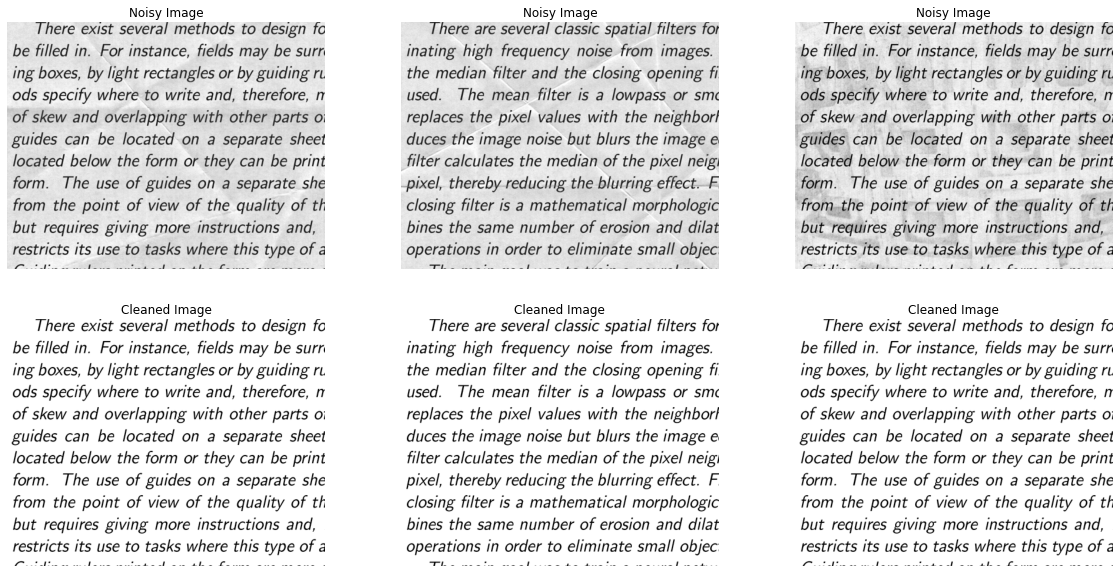

In [205]:
f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, (img_path, cleaned_path) in enumerate(zip(train_images_noisy, cleaned_images)):
    
    img = imread(img_path, as_gray=True)
    cleaned = imread(cleaned_path, as_gray=True)
    
    ax[0, i].imshow(img, cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title('Noisy Image')
    
    ax[1, i].imshow(cleaned, cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title('Cleaned Image')
    
plt.show()

### The code below does the pre processing

In [206]:
### 
# Autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Get list of image file names
train_ipath = os.listdir(train)
train_icleaned = os.listdir(train_cleaned)
test_ipath= os.listdir(test)

# Store the images as array list
X = []
Y = []
#print(train_ipath)


for img_name in train_ipath:
    #print(img_name)
    img = load_img(os.path.join(train, img_name), color_mode='grayscale', target_size=(420, 540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img_name in train_icleaned:
    img = load_img(os.path.join(train_cleaned, img_name), color_mode='grayscale', target_size=(420, 540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)

X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)



Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 420, 540, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 420, 540, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 210, 270, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 210, 270, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 105, 135, 64)      0         
                                                                 
 Conv3 (Conv2D)              (None, 105, 135, 64)      36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 210, 270, 64)      0  

### Splitting the data into train and validation data set

In [207]:

    

# Split the dataset into training and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

# Train the model with the image dataset
hist = autoencoder.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_valid, y_valid))



Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)
Epoch 1/10
17/17 [==============================] - 38s 2s/step - loss: 0.4042 - val_loss: 0.3511
Epoch 2/10
17/17 [==============================] - 39s 2s/step - loss: 0.3278 - val_loss: 0.2941
Epoch 3/10
17/17 [==============================] - 38s 2s/step - loss: 0.2573 - val_loss: 0.2422
Epoch 4/10
17/17 [==============================] - 38s 2s/step - loss: 0.2270 - val_loss: 0.2212
Epoch 5/10
17/17 [==============================] - 38s 2s/step - loss: 0.2063 - val_loss: 0.2087
Epoch 6/10
17/17 [==============================] - 38s 2s/step - loss: 0.1920 - val_loss: 0.1954
Epoch 7/10
17/17 [==============================] - 37s 2s/step - loss: 0.1787 - val_loss: 0.1841
Epoch 8/10
17/17 [==============================] - 37s 2s/step - loss: 0.1709 - val_loss: 0.1800
Epoch 9/10
17/17 [==============================] - 39s 2s/step - loss: 0.1643 - val_loss: 0.1706
Epoch 10/

### Predicting on the noisy test data

In [263]:
test_path = 'D:/DATA_SCIENCE_MASTERS/Code/Assignments/test_daa/'
test_dir = listdir(test_path)

test_paths = [test_path+x for x in test_dir]

X_test = []

for img_name in test_ipath:
    img = load_img(os.path.join(test, img_name), color_mode='grayscale', target_size=(420, 540))
    img = img_to_array(img).astype('float32')/255.
    X_test.append(img)
    
X_test = np.array(X_test)
print(X_test.shape)

(72, 420, 540, 1)


In [264]:
Y_test = autoencoder.predict(X_test, batch_size=10)

8/8 [==============================] - 3s 307ms/step


In [271]:
print(Y_test[0].shape)

(420, 540, 1)


### Displaying the noisy test data and denoised images

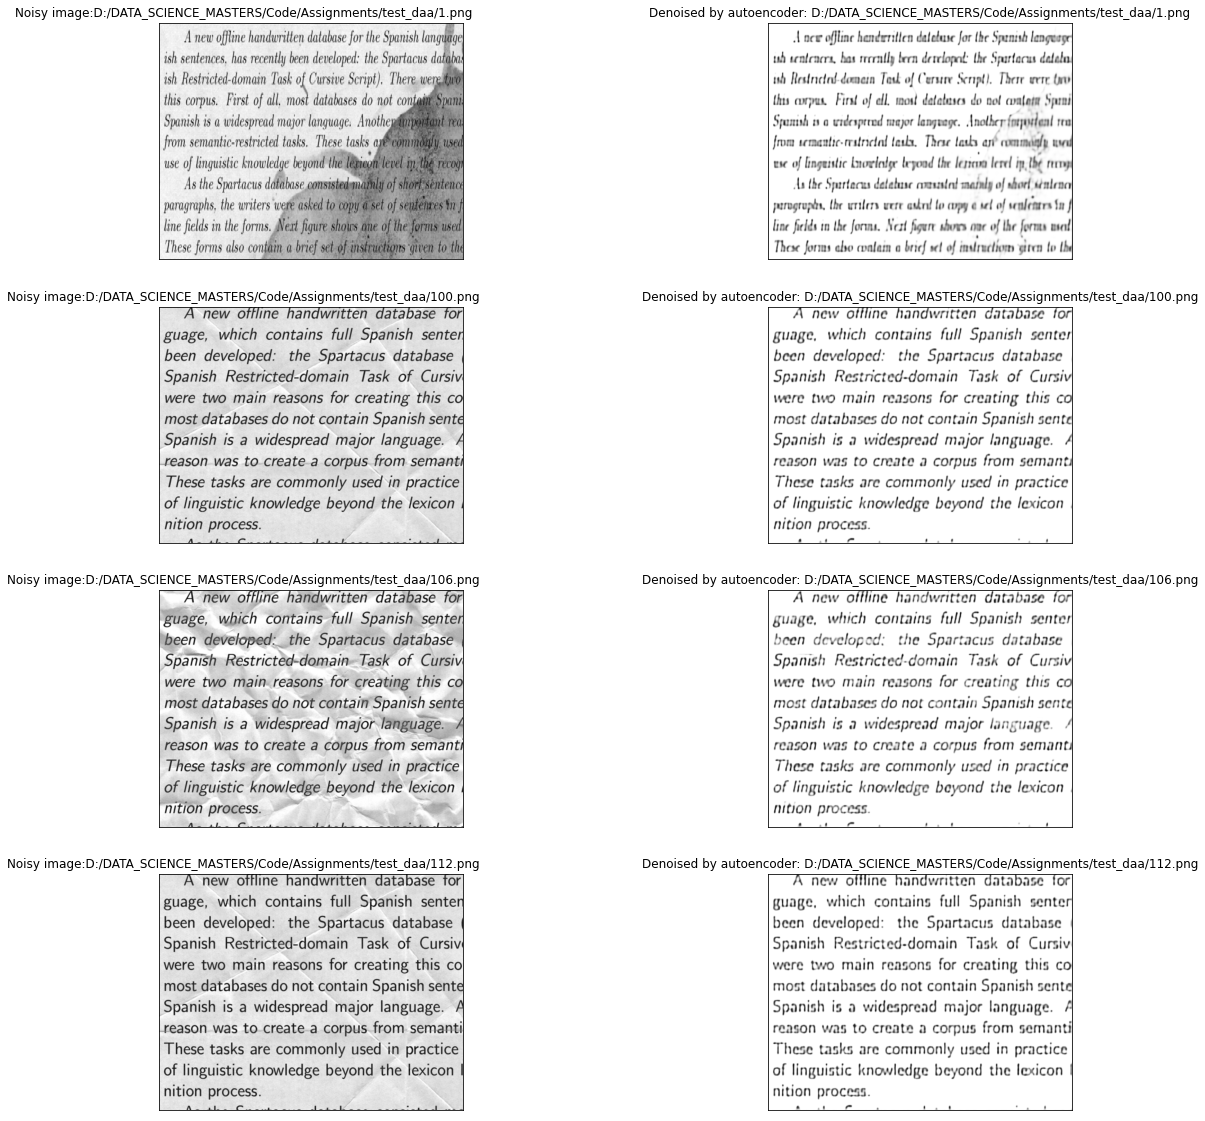

In [265]:
plt.figure(figsize=(20,20))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image:{}                                   ' .format(test_paths[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_paths[i]))

plt.show()

The mean squared error (MSE) is a measure of how different the original and reconstructed images are. A lower MSE indicates a better performance of the autoencoder in reconstructing the input images. However, it is not always a good measure of performance because it does not necessarily capture the visual quality of the reconstructed images

In [ ]:
from skimage.transform import resize

# Resize images to a minimum size of 7x7
X_resized = []
for img in X_test:
   # print(img.shape)
    if img.shape[0] < 7 or img.shape[1] < 7:
        img_resized = resize(img, output_shape=(7, 7), mode='constant', anti_aliasing=True)
    else:
        img_resized = img
    X_resized.append(img_resized)
X_resized = np.array(X_resized)

In [352]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np
import warnings

warnings.filterwarnings('ignore')
# Calculate the performance metrics
mse = []
psnr = []
ssim_scores = []

for i in range(len(X_resized)):
    # Load the original test image
    img_orig = X_resized[i]

    # Calculate mean squared error (MSE)
    mse.append(mean_squared_error(img_orig, Y_resized[i]))

   
    # Calculate structural similarity index (SSIM)
    #ssim_scores.append(structural_similarity(img_orig, Y_test[i], win_size=2, data_range=img_orig.max() - img_orig.min()))
    #ssim_scores.append(structural_similarity(img_orig, Y_test[i], data_range=img_orig.max() - img_orig.min(), win_size=11))
    ssim = structural_similarity(img_orig, Y_resized[i], data_range=1.0, multichannel=True)
    
# Print the performance metrics
print('Mean Squared Error (MSE):', np.mean(mse))
print('Structural Similarity Index (SSIM):', np.mean(ssim))


Mean Squared Error (MSE): 0.04768357223931764
Structural Similarity Index (SSIM): 0.69328445
